# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# import the Data and take a closer look at them

In [3]:
import pickle

def import_and_save_data():
    """ 
    Decription:
    This function loads data from two csv files 
    and saves them in two pickle files (file, file2), 
    in order to shorten the time for loading the data while working in this python notebook
    """
    # load messages dataset 
    azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', delimiter=';')
    customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', delimiter=';')
    
    # Its important to use binary mode 
    file = open('azdias.pickle', 'wb') 
    # source, destination 
    pickle.dump(azdias, file)                      
    file.close() 
    # Its important to use binary mode 
    file2 = open('customers.pickle', 'wb') 
    # source, destination 
    pickle.dump(customers, file2)                      
    file2.close() 

In [4]:
# As it takes about 10-15 minutes to load the origin data, it's better to save them as pickle files
# import_and_save_data()

In [5]:
import time

def load_data(file_name):
    """ 
    Decription:
    This function loads data from two pickle files 
    and saves them into dataframes
    Arguments:
        file_name: pickle file generated in import_and_save_data() function
    Returns:
        df - created dataframe
    """
    s = time.time()
    file = open(file_name,'rb')
    data = pickle.load(file)
    file.close()
    e1 = (time.time() - s)
    print("Time to load: ", (time.time() - s)/60)
    
    return data

In [6]:
# load file (Demographics data for the general population of Germany)
azdias = load_data("data/azdias.pickle")

Time to load:  0.08700295686721801


In [7]:
# load file (Demographics data for customers of a mail-order company)
customers = load_data("data/customers.pickle")

Time to load:  0.019455615679423013


In [8]:
# for now, work only on the small subset, to avoid processing issues
azdias = azdias[0:1500]
customers = customers[0:1500]

In [9]:
# See the data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
# check size of the azdias dataframe
azdias.shape

(1500, 366)

In [11]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,1.500000e+03,1500.000000,1298.000000,1298.000000,136.000000,47.000000,12.000000,0.0,993.000000,1271.000000,...,1211.000000,1294.000000,1294.000000,1294.000000,1237.000000,1298.000000,1271.000000,1500.000000,1500.000000,1500.000000
mean,6.304008e+05,-0.430667,4.529276,10.674114,11.610294,12.978723,14.166667,NaN,13.880161,7.531865,...,2.402147,6.100464,7.680835,6.090417,3.928860,7.683359,3.983478,3.322667,1.516000,2.745333
std,2.278275e+05,1.135805,3.622021,7.722298,4.267314,3.448310,3.809876,NaN,5.113307,14.007716,...,1.198192,2.808525,3.204210,2.698345,1.981659,2.050417,1.917728,1.348987,0.499911,1.031433
min,2.074580e+05,-1.000000,1.000000,0.000000,2.000000,5.000000,8.000000,NaN,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.556660e+05,-1.000000,1.000000,0.000000,8.000000,10.500000,10.000000,NaN,11.000000,1.000000,...,2.000000,4.000000,6.000000,4.000000,2.000000,7.000000,3.000000,3.000000,1.000000,2.000000
50%,6.152920e+05,-1.000000,3.000000,13.000000,12.000000,13.000000,15.500000,NaN,15.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,7.967245e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.250000,NaN,18.000000,9.000000,...,4.000000,8.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,3.000000
max,1.078734e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,NaN,24.000000,272.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [13]:
def check_nan_values_in_columns(data_frame):
    """ 
    Decription:
    This function calculates percentage of NaN values in each column
    and saves the output into a new data frame.
    Arguments:
        data_frame: dataset for analysis
    Returns:
        df_nan_values: 
    """
    df_nan_values = pd.DataFrame([col, (data_frame[col].isnull().sum() / data_frame.shape[0])*100] for col in data_frame.columns)
    print('Nan values in %:\n', round(df_nan_values,2))
    print('First ten elements with the highest % of NaN values:\n', df_nan_values.sort_values(by=1, ascending=False).head(10))
    
    return df_nan_values

In [14]:
def visualize_nan_values(data_frame):
    """ 
    Decription:
    This function visualizes percentage of NaN values in each column.
    Arguments:
        data_frame: dataset for analysis
    """
    plt.figure(figsize=(15,6))
    plt.hist(data_frame[1], bins = np.linspace(10,100,30), facecolor='b')
    plt.xlabel('Number of NaN value')
    plt.ylabel('Number of columns')
    plt.title('Distribution of NaN values in each column')
    plt.grid(True)
    plt.show()

In [15]:
df_azdias_nan_values = check_nan_values_in_columns(azdias)

Nan values in %:
                         0      1
0                     LNR   0.00
1                AGER_TYP   0.00
2              AKT_DAT_KL  13.47
3                ALTER_HH  13.47
4             ALTER_KIND1  90.93
..                    ...    ...
361        WOHNDAUER_2008  13.47
362              WOHNLAGE  15.27
363              ZABEOTYP   0.00
364             ANREDE_KZ   0.00
365  ALTERSKATEGORIE_GROB   0.00

[366 rows x 2 columns]
First ten elements with the highest % of NaN values:
                                0           1
7                    ALTER_KIND4  100.000000
6                    ALTER_KIND3   99.200000
5                    ALTER_KIND2   96.866667
4                    ALTER_KIND1   90.933333
100                    EXTSEL992   76.666667
300                 KK_KUNDENTYP   68.800000
8           ALTERSKATEGORIE_FEIN   33.800000
85   D19_VERSAND_ONLINE_QUOTE_12   33.000000
62                     D19_LOTTO   33.000000
36    D19_BANKEN_ONLINE_QUOTE_12   33.000000


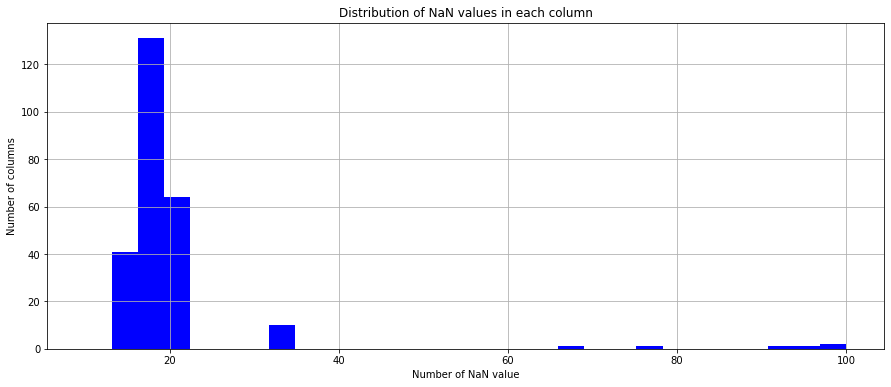

In [16]:
visualize_nan_values(df_azdias_nan_values)

In [17]:
# remove columns with over 60% NaN values:
columns_to_drop = azdias.columns[df_azdias_nan_values.sort_values(by=1,ascending=False).head(6).index]

In [18]:
# check the columns
columns_to_drop

Index(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [19]:
# check the size before dropping the columns:
print("Number of columns before dropping:", azdias.shape[1])
# drop the columns:
azdias = azdias.drop(columns_to_drop, axis = 1)
# check the size after dropping the columns:
print("Number of columns after dropping:", azdias.shape[1])

Number of columns before dropping: 366
Number of columns after dropping: 360


In [20]:
# See the data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [21]:
# check size of the customers dataframe
customers.shape

(1500, 369)

In [22]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,1500.000000,1500.00000,870.000000,870.000000,89.000000,39.000000,15.000000,2.000000,835.000000,852.000000,...,864.000000,864.000000,864.000000,832.000000,870.000000,852.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,99812.392667,0.00200,1.745977,11.435632,12.168539,13.717949,15.066667,15.000000,10.507784,5.951878,...,4.273148,4.567130,3.225694,4.094952,8.545977,3.826291,2.668000,0.084667,1.418667,2.756667
std,56049.675596,1.33486,1.999097,6.259988,3.802619,2.874101,2.051712,4.242641,4.250363,23.030686,...,2.936078,2.923534,2.230358,1.971365,1.369427,2.142484,1.035289,0.278478,0.493505,1.145279
min,2811.000000,-1.00000,1.000000,0.000000,5.000000,7.000000,12.000000,12.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,49706.750000,-1.00000,1.000000,8.000000,9.000000,12.000000,13.000000,13.500000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,3.000000,0.000000,1.000000,2.000000
50%,102326.000000,-1.00000,1.000000,11.000000,12.000000,14.000000,15.000000,15.000000,10.000000,1.000000,...,3.000000,4.000000,3.000000,4.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,142588.750000,1.00000,1.000000,16.000000,15.000000,16.000000,16.500000,16.500000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.00000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,10.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,4.000000


In [23]:
df_customers_nan_values = check_nan_values_in_columns(customers)

Nan values in %:
                         0      1
0                     LNR   0.00
1                AGER_TYP   0.00
2              AKT_DAT_KL  42.00
3                ALTER_HH  42.00
4             ALTER_KIND1  94.07
..                    ...    ...
364         PRODUCT_GROUP   0.00
365        CUSTOMER_GROUP   0.00
366       ONLINE_PURCHASE   0.00
367             ANREDE_KZ   0.00
368  ALTERSKATEGORIE_GROB   0.00

[369 rows x 2 columns]
First ten elements with the highest % of NaN values:
                   0          1
7       ALTER_KIND4  99.866667
6       ALTER_KIND3  99.000000
5       ALTER_KIND2  97.400000
4       ALTER_KIND1  94.066667
300    KK_KUNDENTYP  67.000000
100       EXTSEL992  58.933333
148   KBA05_KRSOBER  46.133333
143  KBA05_KRSAQUOT  46.133333
136       KBA05_GBZ  46.133333
137    KBA05_HERST1  46.133333


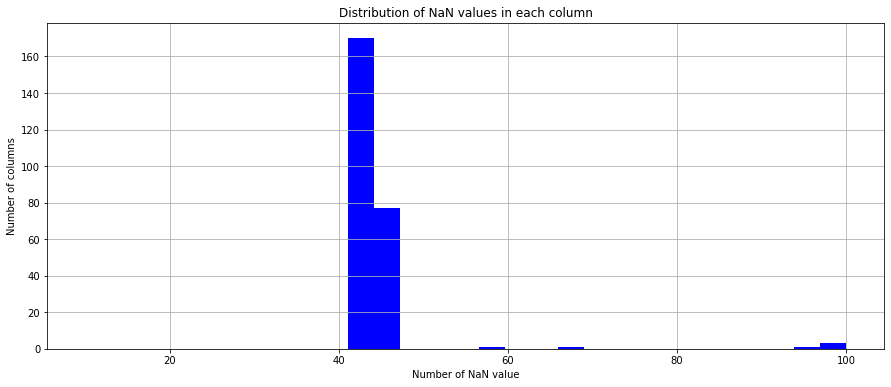

In [24]:
visualize_nan_values(df_customers_nan_values)

In [25]:
# here are exactly the same columns with very high % of Nan values:
# check the size before dropping the columns:
print("Number of columns before dropping:", customers.shape[1])
# drop the columns:
customers = customers.drop(columns_to_drop, axis = 1)
# check the size after dropping the columns:
print("Number of columns after dropping:", customers.shape[1])

Number of columns before dropping: 369
Number of columns after dropping: 363


In [26]:
# number of columns differs, here check why:
azdias_col = azdias.columns
customers_col = customers.columns

common_cols = azdias_col.intersection(customers_col)
different_cols = customers_col.difference(azdias_col)
# check common column names
print(common_cols)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=360)


In [27]:
# check columns that differs:
print(different_cols)

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')


In [28]:
# remove additional columns form azdias dataframe (not needed for the comparison)
customers = customers.drop(different_cols, axis = 1)

In [29]:
# check the size (should be equal number of columns)
print('Number of columns in azdias dataFrame: ', len(azdias.columns))
print('Number of columns in customers dataFrame: ', len(customers.columns))

Number of columns in azdias dataFrame:  360
Number of columns in customers dataFrame:  360


In [30]:
## CHECK OTHER FEATURES TO REDUCE NUMBER OF COLUMNS
# Show dtypes of columns
azdias.dtypes.value_counts()

float64    261
int64       93
object       6
dtype: int64

In [31]:
customers.dtypes.value_counts()

float64    261
int64       93
object       6
dtype: int64

In [32]:
# check categorical variables
categorical_var_azdias = azdias.select_dtypes(include=['object'])
categorical_var_customers = customers.select_dtypes(include=['object'])

In [33]:
categorical_var_azdias

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
1495,8D,8,55,NaN,1992-02-10 00:00:00,W
1496,6D,6,35,D19_VERSAND_REST,1992-02-10 00:00:00,W
1497,3D,3,25,D19_WEIN_FEINKOST,1992-02-12 00:00:00,W
1498,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
categorical_var_customers

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
1495,6C,6,44,D19_BEKLEIDUNG_REST,1992-02-12 00:00:00,W
1496,4D,4,24,D19_VERSICHERUNGEN,1992-02-10 00:00:00,W
1497,3D,3,25,D19_ENERGIE,1992-02-10 00:00:00,W
1498,9A,9,52,D19_SONSTIGE,1992-02-10 00:00:00,W


In [35]:
for col in categorical_var_azdias.columns:
    print(col, len(categorical_var_azdias[col].value_counts()))

CAMEO_DEU_2015 44
CAMEO_DEUG_2015 9
CAMEO_INTL_2015 21
D19_LETZTER_KAUF_BRANCHE 34
EINGEFUEGT_AM 241
OST_WEST_KZ 2


In [36]:
for col in categorical_var_customers.columns:
    print(col, len(categorical_var_customers[col].value_counts()))

CAMEO_DEU_2015 44
CAMEO_DEUG_2015 9
CAMEO_INTL_2015 21
D19_LETZTER_KAUF_BRANCHE 35
EINGEFUEGT_AM 145
OST_WEST_KZ 2


In [37]:
for col in categorical_var_azdias.columns:
    print(col, categorical_var_azdias[col].unique())
## potential issues:
# values: X in CAMEO_DEU_2015,CAMEO_DEUG_2015
# values: XX in CAMEO_INTL_2015

CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015 [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0]
CAMEO_INTL_2015 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0]
D19_LETZTER_KAUF_BRANCHE [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_

In [38]:
# convert X, and XX, to nan values
azdias['CAMEO_DEU_2015'].replace('X', np.NaN, inplace=True)
customers['CAMEO_DEU_2015'].replace('X', np.NaN, inplace=True)

In [39]:
# remove categorical variables with too many categories
azdias = azdias.drop(['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)
customers = customers.drop(['EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE'], axis=1)

In [40]:
# remove CAMEO_INTL_2015 and CAMEO_DEUG_2015 -> very similar to 'CAMEO_DEU_2015'
azdias = azdias.drop(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], axis=1)
customers = customers.drop(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], axis=1)

In [41]:
# in 'OST_WEST_KZ' replace O with 0 and W with 1
azdias['OST_WEST_KZ'].replace('O', 0, inplace=True)
azdias['OST_WEST_KZ'].replace('W', 1, inplace=True)
customers['OST_WEST_KZ'].replace('O', 0, inplace=True)
customers['OST_WEST_KZ'].replace('W', 1, inplace=True)

In [42]:
# check unique values in columns
pd.DataFrame([col, len(azdias[col].unique())] for col in azdias.columns).sort_values(by=1, ascending=False)

,0,1
0,LNR,1500
183,KBA13_ANZAHL_PKW,680
102,GEBURTSJAHR,90
5,ANZ_HAUSHALTE_AKTIV,58
9,ANZ_STATISTISCHE_HAUSHALTE,53
...,...,...
307,OST_WEST_KZ,3
107,HH_DELTA_FLAG,3
70,D19_TELKO_ONLINE_QUOTE_12,2
105,GREEN_AVANTGARDE,2


In [43]:
# remove 'LNR' - kind of ID? - unique to every input
azdias = azdias.drop('LNR',axis=1)
customers = customers.drop('LNR',axis=1)

In [44]:
categorical_cols = list(azdias.select_dtypes(['object']).columns)
num_cols = list(azdias.select_dtypes(['int64', 'float64']).columns)

In [45]:
# in CAMEO_DEU_2015, switch from categorical to numerical
categorical_pipeline = Pipeline([
    ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

num_pipeline = Pipeline([
    ('num_scale', StandardScaler())])

column_transformer = ColumnTransformer([('categorical', categorical_pipeline, categorical_cols),('numerical',num_pipeline, num_cols)])

In [46]:
# fit OneHotEncoder
azdias_trans = column_transformer.fit_transform(azdias)
customers_trans = column_transformer.fit_transform(customers)

In [47]:
# Get column names
col_names = list(column_transformer.transformers_[0][1].named_steps['onehot'].get_feature_names(categorical_cols))

In [48]:
col_names = col_names + num_cols

In [49]:
azdias_trans.shape

(1500, 398)

In [50]:
# Create transformed dataframe
azdias = pd.DataFrame(azdias_trans, columns = [col_names])
customers = pd.DataFrame(customers_trans, columns = [col_names])

In [51]:
# check now number of columns 
print('Number of columns in azdias dataFrame: ', len(azdias.columns))
print('Number of columns in customers dataFrame: ', len(customers.columns))

Number of columns in azdias dataFrame:  398
Number of columns in customers dataFrame:  398


In [52]:
## check rows:
# nan values per row
azdias_nan_rows = azdias.isnull().sum(axis=1)

In [53]:
# nan values per row in %
azdias_nan_values = (1-azdias.count(axis=1)/len(azdias.columns)).sort_values(ascending = False) 
customers_nan_values = (1-customers.count(axis=1)/len(customers.columns)).sort_values(ascending = False) 

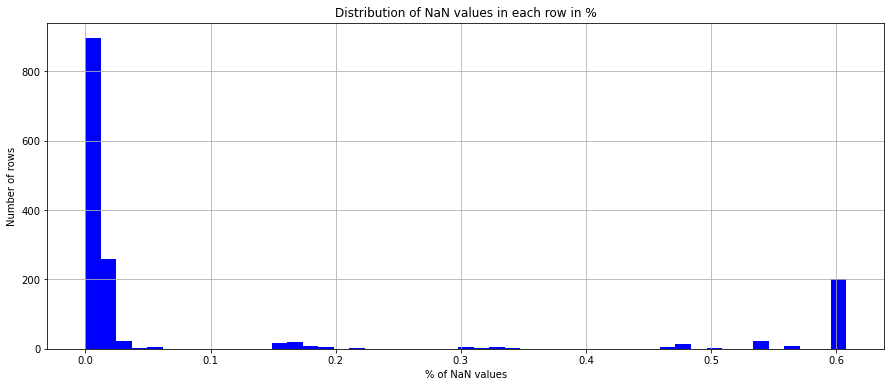

In [54]:
plt.figure(figsize=(15,6))
plt.hist(azdias_nan_values, bins = np.linspace(min(azdias_nan_values),max(azdias_nan_values)), facecolor='b')
plt.xlabel('% of NaN values')
plt.ylabel('Number of rows')
plt.title('Distribution of NaN values in each row in %')
plt.grid(True)
plt.show()

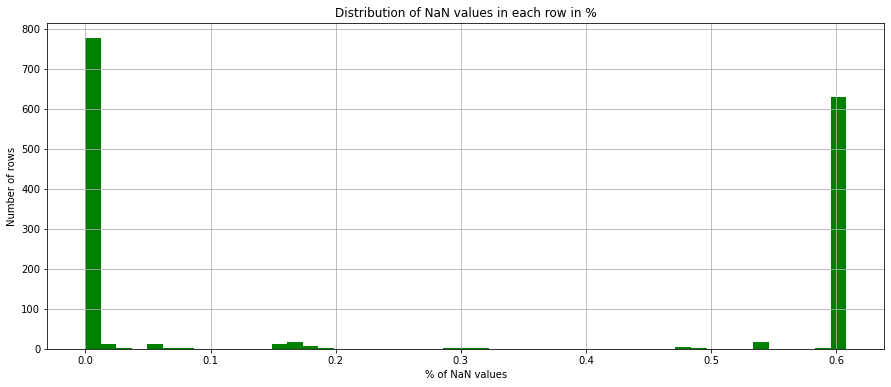

In [55]:
plt.figure(figsize=(15,6))
plt.hist(customers_nan_values, bins = np.linspace(min(customers_nan_values),max(customers_nan_values)), facecolor='g')
plt.xlabel('% of NaN values')
plt.ylabel('Number of rows')
plt.title('Distribution of NaN values in each row in %')
plt.grid(True)
plt.show()

In [56]:
azdias_without_nan_values = azdias[azdias_nan_values <= 0.6]
azdias_without_nan_values

<ipython-input-56-994d7470befd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  azdias_without_nan_values = azdias[azdias_nan_values <= 0.6]


,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.334104,0.676608,1.036277,1.449442,-0.468918,0.642381,0.008619,1.243817,0.968496,-1.692708
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.335767,1.032805,0.411857,-0.033521,-0.468918,0.642381,-1.034692,1.243817,0.968496,0.246988
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-2.005637,0.320412,0.724067,1.820182,NaN,0.642381,1.573586,-0.239272,0.968496,1.216836
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.335767,-1.104374,-0.836983,-0.775003,-0.973750,0.642381,-0.513037,0.502273,-1.032529,0.246988
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.335767,1.389001,-0.212563,-0.775003,1.045577,0.642381,1.573586,0.502273,0.968496,-1.692708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.334104,-1.104374,-0.524773,1.078701,NaN,-1.797087,-0.513037,-0.239272,0.968496,1.216836
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.334104,0.320412,0.724067,0.337219,1.045577,0.642381,-0.513037,-0.239272,-1.032529,0.246988
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.334104,-0.035785,0.411857,0.707960,0.035914,-1.797087,0.008619,-0.239272,0.968496,1.216836
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.334104,-0.391981,-1.461404,-1.516484,1.045577,0.642381,-1.556348,-1.722360,-1.032529,0.246988


In [57]:
customers_without_nan_values = customers[customers_nan_values <= 0.65]
customers_without_nan_values

<ipython-input-57-bfadd0e604b5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  customers_without_nan_values = customers[customers_nan_values <= 0.65]


,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.463093,0.247702,-0.536350,-0.549869,0.966941,0.331733,1.482192,0.320790,-0.848636,1.085978
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,0.588490,0.490400,-0.101251,-2.078466,0.331733,NaN,0.320790,-0.848636,1.085978
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.348260,1.951641,2.886149,3.487695,0.966941,0.331733,-0.852918,0.320790,1.178361,1.085978
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.422073,0.588490,-0.194100,-0.549869,NaN,0.331733,1.482192,-1.611681,-0.848636,1.085978
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.348260,-0.433873,0.148150,0.347368,-1.063330,0.331733,-0.385896,-1.611681,-0.848636,0.212537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.463093,-0.433873,0.148150,0.347368,-1.570898,0.331733,-1.319941,-0.645445,1.178361,1.085978
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.307240,-1.115449,-1.220850,-0.998487,-0.555762,0.331733,-0.852918,-0.645445,1.178361,1.085978
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.192406,-1.115449,-0.878600,-0.101251,-1.570898,0.331733,0.548148,1.287026,1.178361,0.212537
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.422073,0.929278,0.490400,-0.101251,-0.048195,0.331733,-0.385896,0.320790,1.178361,0.212537


In [58]:
# leave only rows that have less than 40% nan values
azdias = azdias_without_nan_values
customers = customers_without_nan_values

In [59]:
def fill_nan_columns(df, columns, types):
    for col in columns:
        if types == 'int':
            df[col]=df[col].fillna(df[col].mean())
        if types == 'float':
            df[col]=df[col].fillna(df[col].median())
    return df

In [60]:
int_cols = list(azdias.select_dtypes(['int64']).columns)
float_cols = list(azdias.select_dtypes(['float64']).columns)

In [61]:
azdias = fill_nan_columns(azdias, int_cols, 'int')
azdias = fill_nan_columns(azdias, float_cols, 'float')
customers = fill_nan_columns(customers, int_cols, 'int')
customers = fill_nan_columns(customers, float_cols, 'float')

In [62]:
azdias.shape

(1298, 398)

In [63]:
customers.shape

(1500, 398)

In [64]:
azdias.dtypes.value_counts()

float64    398
dtype: int64

In [65]:
customers.dtypes.value_counts()

float64    398
dtype: int64

In [66]:
# check nan values in dataset
azdias.isnull().sum(axis = 0).sum()

0

In [67]:
# check nan values in dataset
customers.isnull().sum(axis = 0).sum()

0

In [68]:
def load_csv_data(file_name):
    """ 
    Decription:
    This function loads data from two csv files 
    """
    # load messages dataset 
    data = pd.read_csv(file_name, delimiter=';')
    return data

In [69]:
#save and continue
azdias.to_csv('data/azdias_cleaned.csv', sep=';', index=False)
customers.to_csv('data/customers_cleaned.csv', sep=';', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [82]:
## PCA
azdias_cleaned = load_csv_data('data/azdias_cleaned.csv')
customers_cleaned = load_csv_data('data/customers_cleaned.csv')

In [209]:
def do_and_show_PCA(data):
    """ 
    Decription:
    This function creates PCA model, calculates how many components explain most of the data
    and finally plots output
    Arguments:
        data: input dataframe
    """
    
    pca = PCA().fit(data)
    cumulative_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
    cumulative_variance.set_index(cumulative_variance.index+1, inplace=True)
    num_components = cumulative_variance[cumulative_variance['cumulative_variance']>.95].index[0]
    print(num_components, 'components explain 95% of variance in the dataset.')
    
    plt.figure(figsize=(25,12))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()

def return_pca(data, num_components):
    """ 
    Decription:
    This function returns pca model
    Arguments:
        data: input dataframe
        num_components: number of components with high variance
    Returns:
        pca: created PCA mode
    """
    
    pca = PCA(n_components = num_components).fit(data)

    return pca

def reduce_data(data, num_components):
    """ 
    Decription:
    This function reduces dataset, leaving only crucial features
    Arguments:
        data: input dataframe
        num_components: number of components with high variance
    Returns:
        reduced_data: dataframe with reduced features (columns)
    """
    
    pca = return_pca(data, num_components)
    reduced_data = pd.DataFrame(pca.transform(data))

    return reduced_data

199 components explain 95% of variance in the dataset.


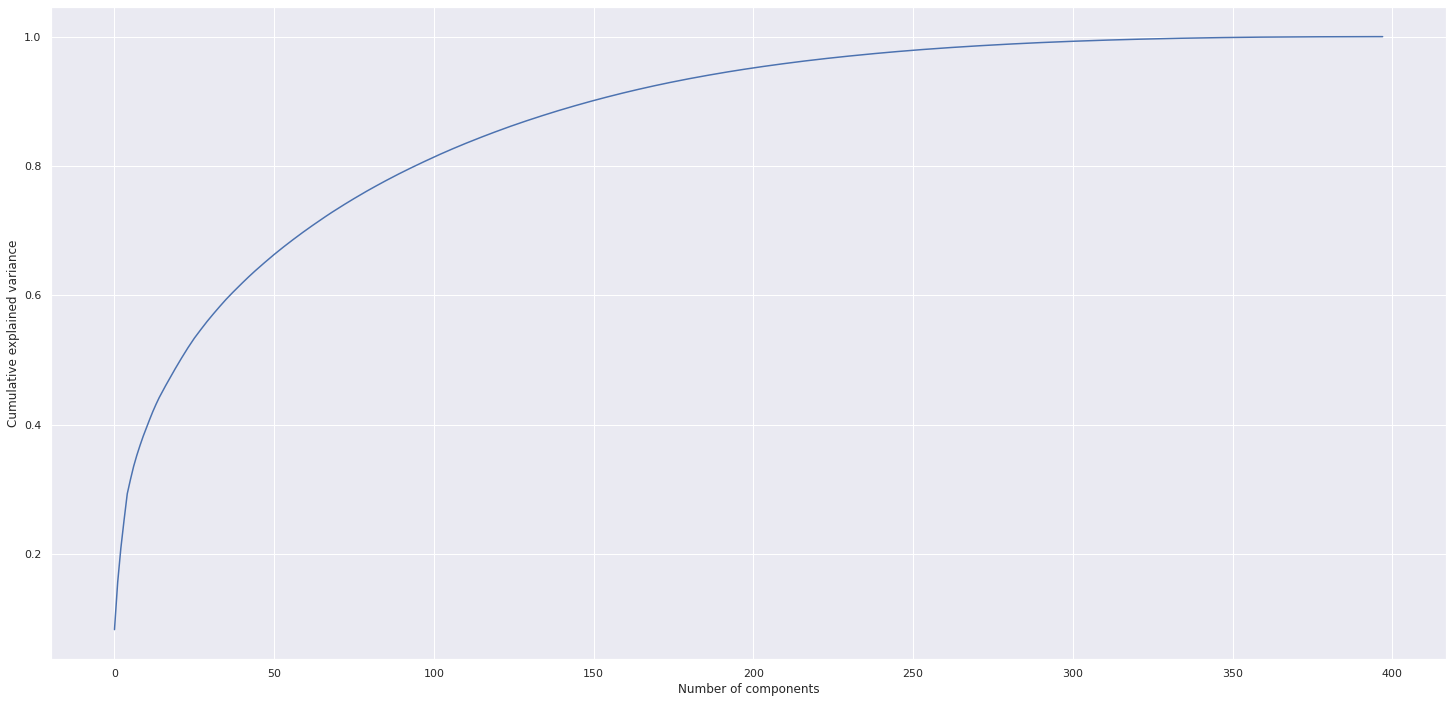

In [206]:
# cleaned dataset has 398 different features. In order to reduce this number, PCA is used here
do_and_show_PCA(azdias_cleaned)

In [210]:
azdias_reduced = reduce_data(azdias_cleaned, 199)
print("Size: ", azdias_reduced.shape)

Size:  (1298, 199)


In [211]:
customers_reduced = reduce_data(customers_cleaned, 199)
print("Size: ", customers_reduced.shape)

Size:  (1500, 199)


In [110]:
## Clustering
from sklearn.cluster import KMeans

def do_and_show_clustering(data):
    #creating data for the plot SSE VS cluster count
    score = []
    k_list = list(range(1, 25))

    for i in k_list:
        kmean = KMeans(i+1)
        model = kmean.fit(data)
        score.append(abs(model.score(data)))
    
    #plotting the cluster curve
    plt.figure(figsize=(20, 10))
    plt.plot(k_list, score, marker='o')
    plt.xlabel('Number of clusters (k)');
    plt.ylabel('Sum of squered distance (SSE)');
    plt.title('k-means clustering elbow')


In [180]:
#refit the model to 13 cluster
kmean = KMeans(13)
model = kmean.fit(azdias_reduced)
azdias_prediction = pd.DataFrame(model.predict(azdias_reduced), columns = ['Cluster'])
customers_prediction = pd.DataFrame(model.predict(customers_reduced), columns = ['Cluster'])

In [181]:
# Get number of items / cluster
count_azdias_clustered = azdias_prediction.value_counts().sort_index()
count_customers_clustered = customers_prediction.value_counts().sort_index()
count_azdias_clustered

Cluster
0           86
1           62
2          144
3          156
4           24
5          156
6           69
7          119
8           93
9          112
10         130
11           3
12         144
dtype: int64

In [182]:
count_customers_clustered

Cluster
0          150
1           14
2          253
3          134
4            6
5          624
6           36
7          143
9            3
10          19
12         118
dtype: int64

In [183]:
# Concat both dataframes to one
clusters = pd.concat([count_azdias_clustered, count_customers_clustered], axis = 1).reset_index()
clusters.columns = ['cluster','population', 'customers']

In [184]:
# Calculate share of each cluster
clusters['population_share'] = (clusters['population']/clusters['population'].sum()*100).round(2)
clusters['customers_share'] = (clusters['customers']/clusters['customers'].sum()*100).round(2)
clusters['difference_share'] = clusters['customers_share'] - clusters['population_share']
clusters_diff = pd.concat([clusters['population_share'], clusters['customers_share']], axis = 1)

In [185]:
clusters

,cluster,population,customers,population_share,customers_share,difference_share
0,0,86,150.0,6.63,10.00,3.37
1,1,62,14.0,4.78,0.93,-3.85
2,2,144,253.0,11.09,16.87,5.78
3,3,156,134.0,12.02,8.93,-3.09
4,4,24,6.0,1.85,0.40,-1.45
5,5,156,624.0,12.02,41.60,29.58
6,6,69,36.0,5.32,2.40,-2.92
7,7,119,143.0,9.17,9.53,0.36
8,8,93,NaN,7.16,NaN,NaN
9,9,112,3.0,8.63,0.20,-8.43


In [186]:
## visualize the output function
def visualize_data(fig_size_x, fig_size_y, df, legend, title, color, xlabel, ylabel):
    """ 
    Decription:
    This function visualizes data using bar plot.
    Arguments:
        fig_size_x: figure size x
        fig_size_y: figure size y
        df: given data subset
        legend: boolean value, legend visible or not
        title: title of the plot
        color: color of the bar
        xlabel: x label
        ylabel: y label
    Returns:
        None
    """
    sns.set(rc={'figure.figsize':(fig_size_x,fig_size_y)})
    df.plot(kind='bar', legend = legend, title = title, color = color, xlabel=xlabel, ylabel=ylabel)

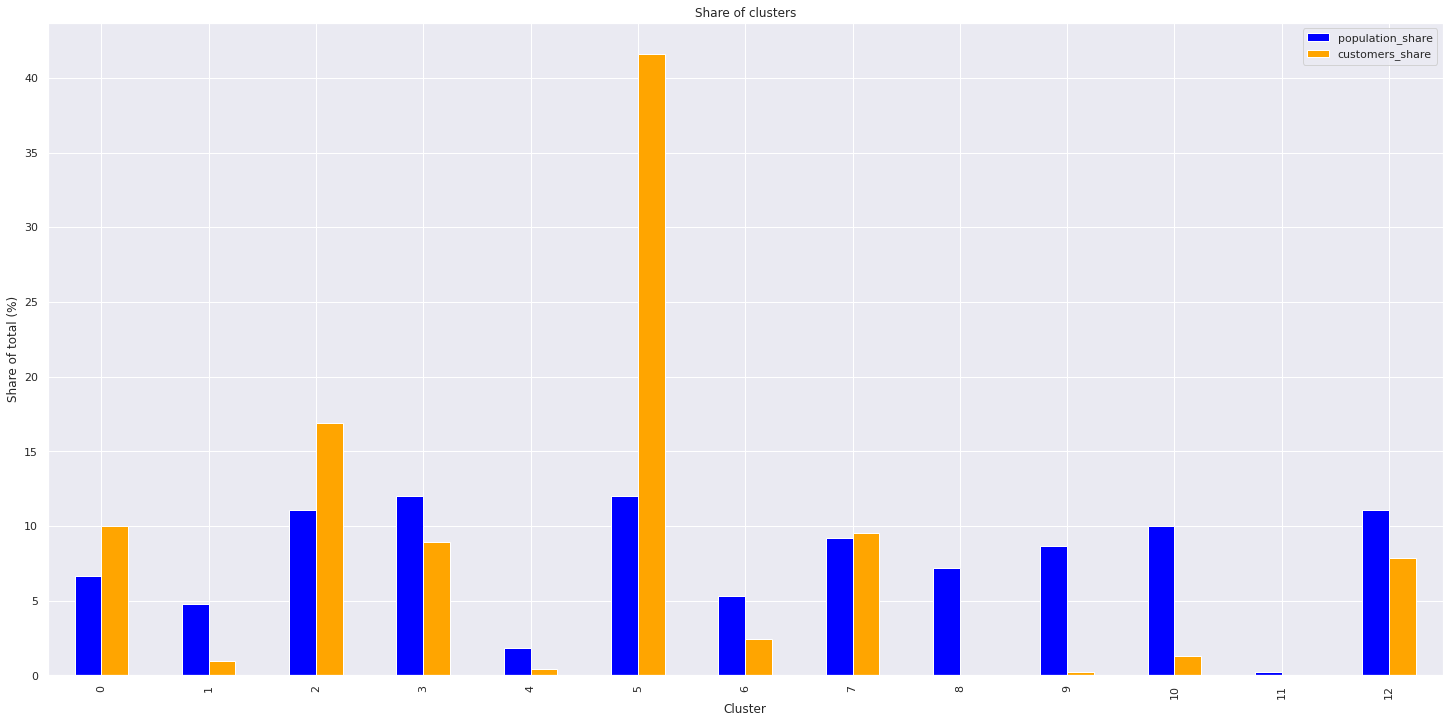

In [187]:
# visualize clusters
visualize_data(25, 12, clusters_diff, True, 'Share of clusters', ['blue', 'orange'], 'Cluster', 'Share of total (%)')

In [188]:
clusters['difference_share']

0      3.37
1     -3.85
2      5.78
3     -3.09
4     -1.45
5     29.58
6     -2.92
7      0.36
8       NaN
9     -8.43
10    -8.75
11      NaN
12    -3.22
Name: difference_share, dtype: float64

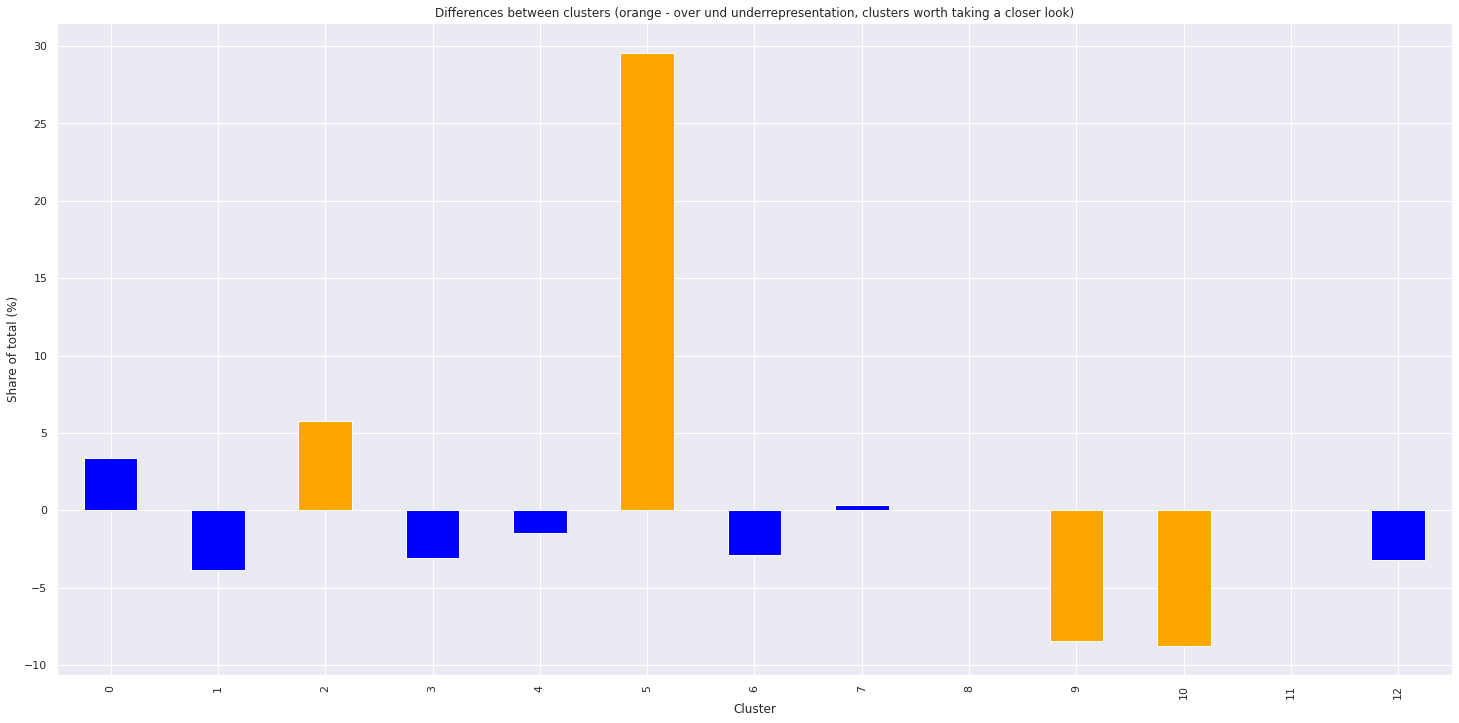

In [203]:
# visualize differences
visualize_data(25, 12, clusters['difference_share'], False, 'Differences between clusters (orange - over und underrepresentation, clusters worth taking a closer look)', np.where(abs(clusters['difference_share']) < 5, 'blue', 'orange'), 'Cluster', 'Share of total (%)')

In [213]:
pca = return_pca(azdias_cleaned, 199)

In [248]:
# Show Highest Positives and Negatives
def pca_weights(cluster, weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias_cleaned.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1)
    #result[:5],
    print('\n')
    print("Parts of the general population that are more likely to be part of the mail-order company's main customer base:")
    print(result.iloc[(cluster)-1].sort_values(ascending=False)[:weight_num])
    print("Parts of the general population that are less likely to be part of the mail-order company's main customer base:")
    print(result.iloc[(cluster)-1].sort_values()[:weight_num])

pca_weights(5,10)



Parts of the general population that are more likely to be part of the mail-order company's main customer base:
FINANZ_VORSORGER        0.181
ALTERSKATEGORIE_GROB    0.175
CJT_TYP_5               0.159
CJT_TYP_3               0.148
CJT_TYP_4               0.145
AGER_TYP                0.141
SEMIO_LUST              0.139
CJT_TYP_6               0.134
SEMIO_ERL               0.128
RETOURTYP_BK_S          0.117
Name: 4, dtype: float64
Parts of the general population that are less likely to be part of the mail-order company's main customer base:
FINANZ_SPARER           -0.183
CJT_TYP_1               -0.177
SEMIO_PFLICHT           -0.171
CJT_TYP_2               -0.169
SEMIO_TRADV             -0.168
FINANZ_UNAUFFAELLIGER   -0.164
RT_KEIN_ANREIZ          -0.158
FINANZ_ANLEGER          -0.150
SEMIO_RAT               -0.143
PRAEGENDE_JUGENDJAHRE   -0.142
Name: 4, dtype: float64


In [257]:
def reconstruct_component(df, model, cluster, pca, weight_num):
    #reversing the reduction to get back to the original features
    output_pos_first = pd.DataFrame({'Features':list(df.keys()),'Values':pca.inverse_transform(model.cluster_centers_)[cluster]}).sort_values('Values', axis=0, ascending=False).values
    output_neg_first = pd.DataFrame({'Features':list(df.keys()),'Values':pca.inverse_transform(model.cluster_centers_)[cluster]}).sort_values('Values', axis=0, ascending=True).values
    print('\n')
    print('Cluster', cluster, ':')
    print('\n')
    print("Parts of the general population that are more likely to be part of the mail-order company's main customer base:")
    print('\n')
    print(output_pos_first[:weight_num])
    print("Parts of the general population that are more likely to be part of the mail-order company's main customer base:")
    print(output_neg_first[:weight_num])

reconstruct_component(azdias_cleaned, model, 2, pca, 10)
reconstruct_component(azdias_cleaned, model, 5, pca, 10)

Cluster 2 :


Parts of the general population that are more likely to be part of the mail-order company's main customer base:


[['ONLINE_AFFINITAET' 1.2660979283071485]
 ['D19_VERSAND_ANZ_24' 1.2317586667363662]
 ['D19_GESAMT_ANZ_24' 1.1594838379331867]
 ['D19_VERSAND_ANZ_12' 1.1048607019672365]
 ['D19_GESAMT_ANZ_12' 0.9939947572546137]
 ['D19_VERSAND_ONLINE_QUOTE_12' 0.8656759849162171]
 ['D19_SCHUHE' 0.8061228797349633]
 ['PRAEGENDE_JUGENDJAHRE' 0.7961751128718263]
 ['ANZ_KINDER' 0.7786294604441376]
 ['LP_LEBENSPHASE_FEIN' 0.7733220435952909]]
Parts of the general population that are more likely to be part of the mail-order company's main customer base:
[['D19_VERSAND_ONLINE_DATUM' -1.3379962043398224]
 ['D19_VERSAND_DATUM' -1.319153000721879]
 ['D19_GESAMT_ONLINE_DATUM' -1.2417507187251449]
 ['D19_GESAMT_DATUM' -1.1941620364643362]
 ['D19_KONSUMTYP_MAX' -1.1698200060378954]
 ['VK_DHT4A' -1.045591257360046]
 ['CJT_KATALOGNUTZER' -0.8653806360474895]
 ['W_KEIT_KIND_HH' -0.76068486083

In [249]:
reconstruct_component(azdias_cleaned, model, 2, pca, 10)
features_in_cluster_5[:10]

Cluster 5 positiv:


[['SEMIO_ERL', 0.9304665165488821],
 ['FINANZ_VORSORGER', 0.9141766738015557],
 ['ALTERSKATEGORIE_GROB', 0.8726124421366187],
 ['HH_EINKOMMEN_SCORE', 0.7629217580447558],
 ['CJT_TYP_4', 0.7375373575933529],
 ['FINANZ_HAUSBAUER', 0.725636422932361],
 ['RETOURTYP_BK_S', 0.7191923223799087],
 ['VK_DHT4A', 0.7141744086863858],
 ['AGER_TYP', 0.6318760383490729],
 ['CJT_TYP_3', 0.5751962167764926]]

In [250]:
print('Cluster 5 negativ:')
features_in_cluster_5[-10:]

Cluster 5 negativ:


[['SEMIO_PFLICHT', -0.736888161086602],
 ['SEMIO_TRADV', -0.7619421339254073],
 ['FINANZ_ANLEGER', -0.770848433682176],
 ['FINANZ_SPARER', -0.7813027055147465],
 ['FINANZ_UNAUFFAELLIGER', -0.7863790690587993],
 ['CJT_TYP_2', -0.7894744645748427],
 ['CJT_TYP_1', -0.809598373371627],
 ['RT_UEBERGROESSE', -0.8160719139783214],
 ['SEMIO_REL', -0.858147041388211],
 ['ONLINE_AFFINITAET', -0.9246376335178796]]

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')